<a href="https://colab.research.google.com/github/banned-books/project_banned_books/blob/main/appendix/Top2Vec_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This is the abandoned Top2Vec exploration - BERTopic was proving more useful. 
#Figuring out the optimal way to extract useful words for topic modeling was 
#proving challenging. One of the things I was encountering was that
#names kept coming up as key words, and I went down a path adding names to 
#stopwords to remove them from reviews, including extracting author names.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nameparser.parser import HumanName
from nltk.corpus import wordnet
from top2vec import Top2Vec
import gensim
from gensim import models
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('names')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data] 

True

In [ ]:
banned_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/original_data/banned_books.csv')
banned_df.head()

goodreads_image_url               title  \
0  https://images-na.ssl-images-amazon.com/images...       Ace of Spades   
1  https://images-na.ssl-images-amazon.com/images...  Clap When You Land   
2  https://images-na.ssl-images-amazon.com/images...          The Poet X   
3  https://images-na.ssl-images-amazon.com/images...          The Poet X   
4  https://images-na.ssl-images-amazon.com/images...          The Poet X   

                   author goodreads_published_date  \
0  Àbíké-Íyímídé, Faridah               2021-06-01   
1      Acevedo, Elizabeth               2020-05-05   
2      Acevedo, Elizabeth               2018-03-06   
3      Acevedo, Elizabeth               2018-03-06   
4      Acevedo, Elizabeth               2018-03-06   

                               goodreads_description  \
0  An incendiary and utterly compelling thriller ...   
1  In a novel in verse that brims with grief and ...   
2  Fans of Jacqueline Woodson  Meg Medina  and Ja...   
3  Fans of Jacqueline Woodson  Meg Medina  and Ja...   
4  Fans of Jacqueline Woodson  Meg Medina  and Ja...   

                                      goodreads_tags  \
0  dark, lgbtqia+, black, young adult, gay romanc...   
1  young adult, poetry, contemporary, fiction, au...   
2  poetry, young adult, contemporary, fiction, au...   
3  poetry, young adult, contemporary fiction, aud...   
4  poetry, young adult, contemporary fiction, aud...   

                          type_of_ban         state  \
0  Banned in Libraries and Classrooms       Florida   
1                Banned in Classrooms  Pennsylvania   
2                 Banned in Libraries       Florida   
3  Banned in Libraries and Classrooms      New York   
4        Banned Pending Investigation         Texas   

                                     district        ban_date  \
0         Indian River County School District   November 2021   
1                Central York School District  September 2021   
2         Indian River County School District   November 2021   
3            Marlboro Central School District   February 2022   
4  Fredericksburg Independent School District      March 2022   

  origin_of_challenge                              goodreads_product_url  \
0       Administrator  https://www.goodreads.com/book/show/42603984-a...   
1       Administrator  https://www.goodreads.com/book/show/52516332-c...   
2       Administrator  https://www.goodreads.com/book/show/33294200-t...   
3       Administrator  https://www.goodreads.com/book/show/33294200-t...   
4       Administrator  https://www.goodreads.com/book/show/33294200-t...   

                                          amazon_url secondary_authors  \
0  https://www.amazon.com/Ace-Spades-Faridah-Abik...               NaN   
1  https://www.amazon.com/Clap-When-Land-Elizabet...               NaN   
2  https://www.amazon.com/Poet-X-Elizabeth-Aceved...               NaN   
3  https://www.amazon.com/Poet-X-Elizabeth-Aceved...               NaN   
4  https://www.amazon.com/Poet-X-Elizabeth-Aceved...               NaN   

  illustrators translators  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  
3          NaN         NaN  
4          NaN         NaN

In [ ]:
banned_df.describe()

goodreads_image_url  \
count                                                2532   
unique                                               1616   
top     https://images-na.ssl-images-amazon.com/images...   
freq                                                   41   

                         title          author goodreads_published_date  \
count                     2532            2532                     2532   
unique                    1644            1149                      896   
top     Gender Queer: A Memoir  Hopkins, Ellen               2019-05-28   
freq                        41              43                       43   

                                    goodreads_description  \
count                                                2532   
unique                                               1617   
top     In 2014  Maia Kobabe  who uses e em eir pronou...   
freq                                                   41   

                                           goodreads_tags  \
count                                                2532   
unique                                               1533   
top     graphic novels, lgbt, memoir, nonfiction, quee...   
freq                                                   41   

                         type_of_ban  state                      district  \
count                           2532   2532                          2532   
unique                             4     32                           138   
top     Banned Pending Investigation  Texas  Central York School District   
freq                            1375    801                           441   

             ban_date origin_of_challenge  \
count            2532                2532   
unique             12                   3   
top     December 2021       Administrator   
freq              513                2383   

                                    goodreads_product_url  \
count                                                2532   
unique                                               1620   
top     https://www.goodreads.com/book/show/42837514-g...   
freq                                                   41   

                                               amazon_url secondary_authors  \
count                                                2422               166   
unique                                               1532               100   
top     https://www.amazon.com/Gender-Queer-Memoir-Mai...     Cast, Kristin   
freq                                                   41                12   

        illustrators     translators  
count            546              27  
unique           292              18  
top     Faber, Jules  Beck, Adrienne  
freq              17               7

In [ ]:
banned_df = banned_df.drop_duplicates(subset = 'title', keep = 'first')

banned_df.head()

goodreads_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
6  https://images-na.ssl-images-amazon.com/images...   
7  https://images-na.ssl-images-amazon.com/images...   

                                               title                  author  \
0                                      Ace of Spades  Àbíké-Íyímídé, Faridah   
1                                 Clap When You Land      Acevedo, Elizabeth   
2                                         The Poet X      Acevedo, Elizabeth   
6                               Call Me By Your Name           Aciman, André   
7  How I Paid for College: A Novel of Sex, Theft,...             Acito, Marc   

  goodreads_published_date                              goodreads_description  \
0               2021-06-01  An incendiary and utterly compelling thriller ...   
1               2020-05-05  In a novel in verse that brims with grief and ...   
2               2018-03-06  Fans of Jacqueline Woodson  Meg Medina  and Ja...   
6               2007-01-23  Call Me by Your Name is the story of a sudden ...   
7               2004-01-01  A deliciously funny romp of a novel about one ...   

                                      goodreads_tags  \
0  dark, lgbtqia+, black, young adult, gay romanc...   
1  young adult, poetry, contemporary, fiction, au...   
2  poetry, young adult, contemporary, fiction, au...   
6  queer literature, gay, coming of age, lgbtqia+...   
7  fiction, young adult, humor, lgbt, gay, contem...   

                          type_of_ban         state  \
0  Banned in Libraries and Classrooms       Florida   
1                Banned in Classrooms  Pennsylvania   
2                 Banned in Libraries       Florida   
6        Banned Pending Investigation      Virginia   
7        Banned Pending Investigation       Florida   

                              district        ban_date origin_of_challenge  \
0  Indian River County School District   November 2021       Administrator   
1         Central York School District  September 2021       Administrator   
2  Indian River County School District   November 2021       Administrator   
6   Spotsylvania County Public Schools   November 2021       Administrator   
7  Indian River County School District   November 2021       Administrator   

                               goodreads_product_url  \
0  https://www.goodreads.com/book/show/42603984-a...   
1  https://www.goodreads.com/book/show/52516332-c...   
2  https://www.goodreads.com/book/show/33294200-t...   
6  https://www.goodreads.com/book/show/36336078-c...   
7  https://www.goodreads.com/book/show/123448.How...   

                                          amazon_url secondary_authors  \
0  https://www.amazon.com/Ace-Spades-Faridah-Abik...               NaN   
1  https://www.amazon.com/Clap-When-Land-Elizabet...               NaN   
2  https://www.amazon.com/Poet-X-Elizabeth-Aceved...               NaN   
6  https://www.amazon.com/Call-Me-Your-Name-Novel...               NaN   
7  https://www.amazon.com/How-Paid-College-Friend...               NaN   

  illustrators translators  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  
6          NaN         NaN  
7          NaN         NaN

In [ ]:
descriptions = banned_df['goodreads_description']
tags = banned_df['goodreads_tags']
authors = banned_df['author'].tolist()
second_authors = banned_df['secondary_authors']

print(authors)

['Àbíké-Íyímídé, Faridah', 'Acevedo, Elizabeth', 'Acevedo, Elizabeth', 'Aciman, André', 'Acito, Marc', 'Ada, Alma Flor', 'Addasi, Maha', 'Adeyemi, Tomi', 'Adeyoha, Koja', 'Adichie, Chimamanda Ngozi', 'Adler, Dahlia', 'Agell, Charlotte', 'Ahmadi, Arvin', 'Ahmed, Roda', 'Ahmed, Samira', 'Ahmed, Sara K.', 'Albertalli, Becky', 'Albertalli, Becky', 'Albertalli, Becky', 'Albertalli, Becky', 'Albertalli, Becky', 'Albertalli, Becky', 'Albertalli, Becky', 'Aleman, Daniel', 'Alexander, Kwame', 'Alexander, Michelle', 'Alexie, Sherman', 'Alexie, Sherman', 'Alger, Cristina', 'Alko, Selina', 'Allende, Isabel', 'Alley, Kristy Dallas', 'Allison, Anthony', 'Allman, John Robert', 'Altman, Linda Jacobs', 'Amnesty International', 'Anaya, Rudolfo', 'Ancrum, K.', 'Anders, Charlie Jane', 'Anderson, Airlie', 'Anderson, Carol', 'Anderson, Laurie Halse', 'Anderson, Laurie Halse', 'Anderson, M. T.', 'Andrews, Arin', 'Andrews, Jesse', 'Andrews, Jesse', 'Andrews, Troy', 'Andrews, Troy', 'Angelou, Maya', 'Angelou, 

In [ ]:
author_names = []

for n in authors:
    author_names.extend(n.lower().split(','))
for s in second_authors.tolist():
    try:
        author_names.extend(s.lower().split(',').strip())
    except: continue

author_names = [a.strip() for a in author_names]
print(len(author_names))
print(len(set(author_names)))



#add stopwords
#include Authors in stopwords
#try to incorporate people names in stopwords


3272
1839


In [ ]:
stoplist = ['the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'fish', 'ha', 'bye', 'okay', 'andy', 'wa', 'nt',"a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep",	"keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure",	"t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","chapter", 'condition', 'la',"tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero", "wa", "nt", "ha", "purchased", "ordered", "amazon", "damaged", "book","read","character","story","will","school","student", "people", "parent", "child", "weekend", "people", "person", "well", "doe", "feel", "felt", "cover", "arrived", "described", "addie","não", "write", "writing", "episode", "website", "robin", "kosawa", "emily", "judy", "buch", "gline", "griffin", "patrick", "feyre", "nesta", "de", "purchase","cliff", "carter", "novel", "caroline", "ii", "molly", "aside", "arthur", "academy", "cad", "season", "jennifer", "simon", 'lot', 'ya', "atwood", 'author',"reader", "buy", "copy", "morrison", "story", "storytelling", "reading", "series", "absolutely", "definitely", "go", "going", "bought", "written", "review","book","read","character","story","will", "weekend", "find", "main", "people", "person", "well", "felt", "feel", "scene","não", "write", "writing", "episode", "website", "robin", "kosawa", "emily", "judy", "buch", "gline", "griffin", "patrick", "baz", "lerue", "henry", "cliff", "carter", "novel", "caroline", "ii", "molly", "aside", "arthur", "academy", "cad", "season", "jennifer", "atwood", 'author', "things", "thing", "thought", "wanted", "bit","reader", "buy", "copy", "morrison", "story", "storytelling", "reading", "series", "plot", "audiobook", "narrator", "topic", "addie"]

names_ = [n.lower() for n in nltk.corpus.names.words()]
stoplist.extend(names_)
stoplist.extend(set(author_names))

In [ ]:
print(stoplist)

['the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'fish', 'ha', 'bye', 'okay', 'andy', 'wa', 'nt', 'a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being

In [ ]:
model = Top2Vec(banned_df['goodreads_tags'].tolist())
model.get_num_topics()

2023-03-26 14:52:20,521 - top2vec - INFO - Pre-processing documents for training
2023-03-26 14:52:20,596 - top2vec - INFO - Creating joint document/word embedding
2023-03-26 14:52:22,702 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-26 14:52:31,866 - top2vec - INFO - Finding dense areas of documents
2023-03-26 14:52:31,920 - top2vec - INFO - Finding topics


6

In [ ]:
model.topic_words

array([['childrens', 'lgbt', 'history', 'contemporary', 'paranormal',
        'audiobook', 'lesbian', 'humor', 'banned', 'chapter', 'animals',
        'race', 'sports', 'age', 'coming', 'adult', 'fiction', 'fantasy',
        'thriller', 'cultural', 'transgender', 'poetry', 'queer',
        'books', 'middle', 'mental', 'biography', 'anti', 'science',
        'romance', 'kids', 'grade', 'mystery', 'picture', 'memoir',
        'racist', 'of', 'high', 'graphic', 'juvenile', 'historical',
        'school', 'teen', 'young', 'literature', 'health', 'comics',
        'realistic', 'african', 'magic'],
       ['childrens', 'chapter', 'fiction', 'justice', 'history',
        'health', 'gay', 'education', 'race', 'teen', 'humor',
        'audiobook', 'thriller', 'graphic', 'african', 'picture',
        'banned', 'transgender', 'books', 'contemporary', 'middle',
        'sports', 'nonfiction', 'politics', 'social', 'animals',
        'storytime', 'feminism', 'anti', 'literature', 'lesbian',
       

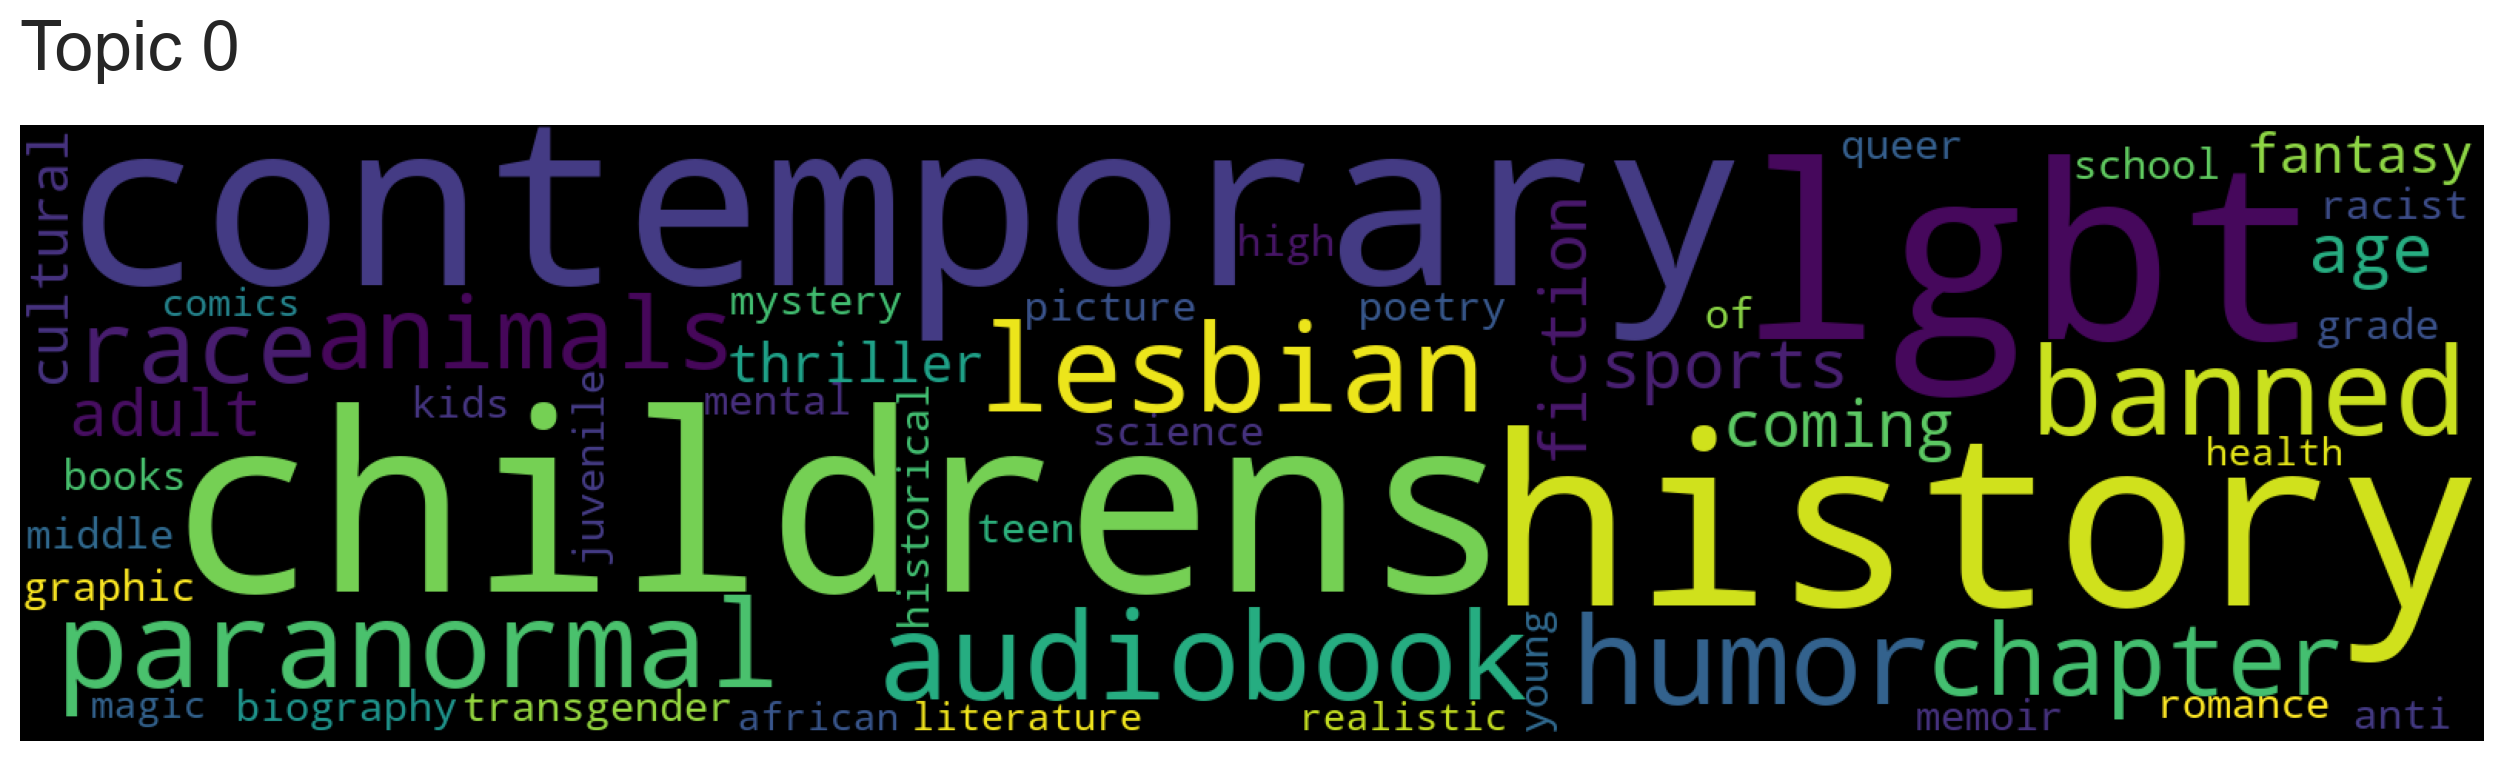

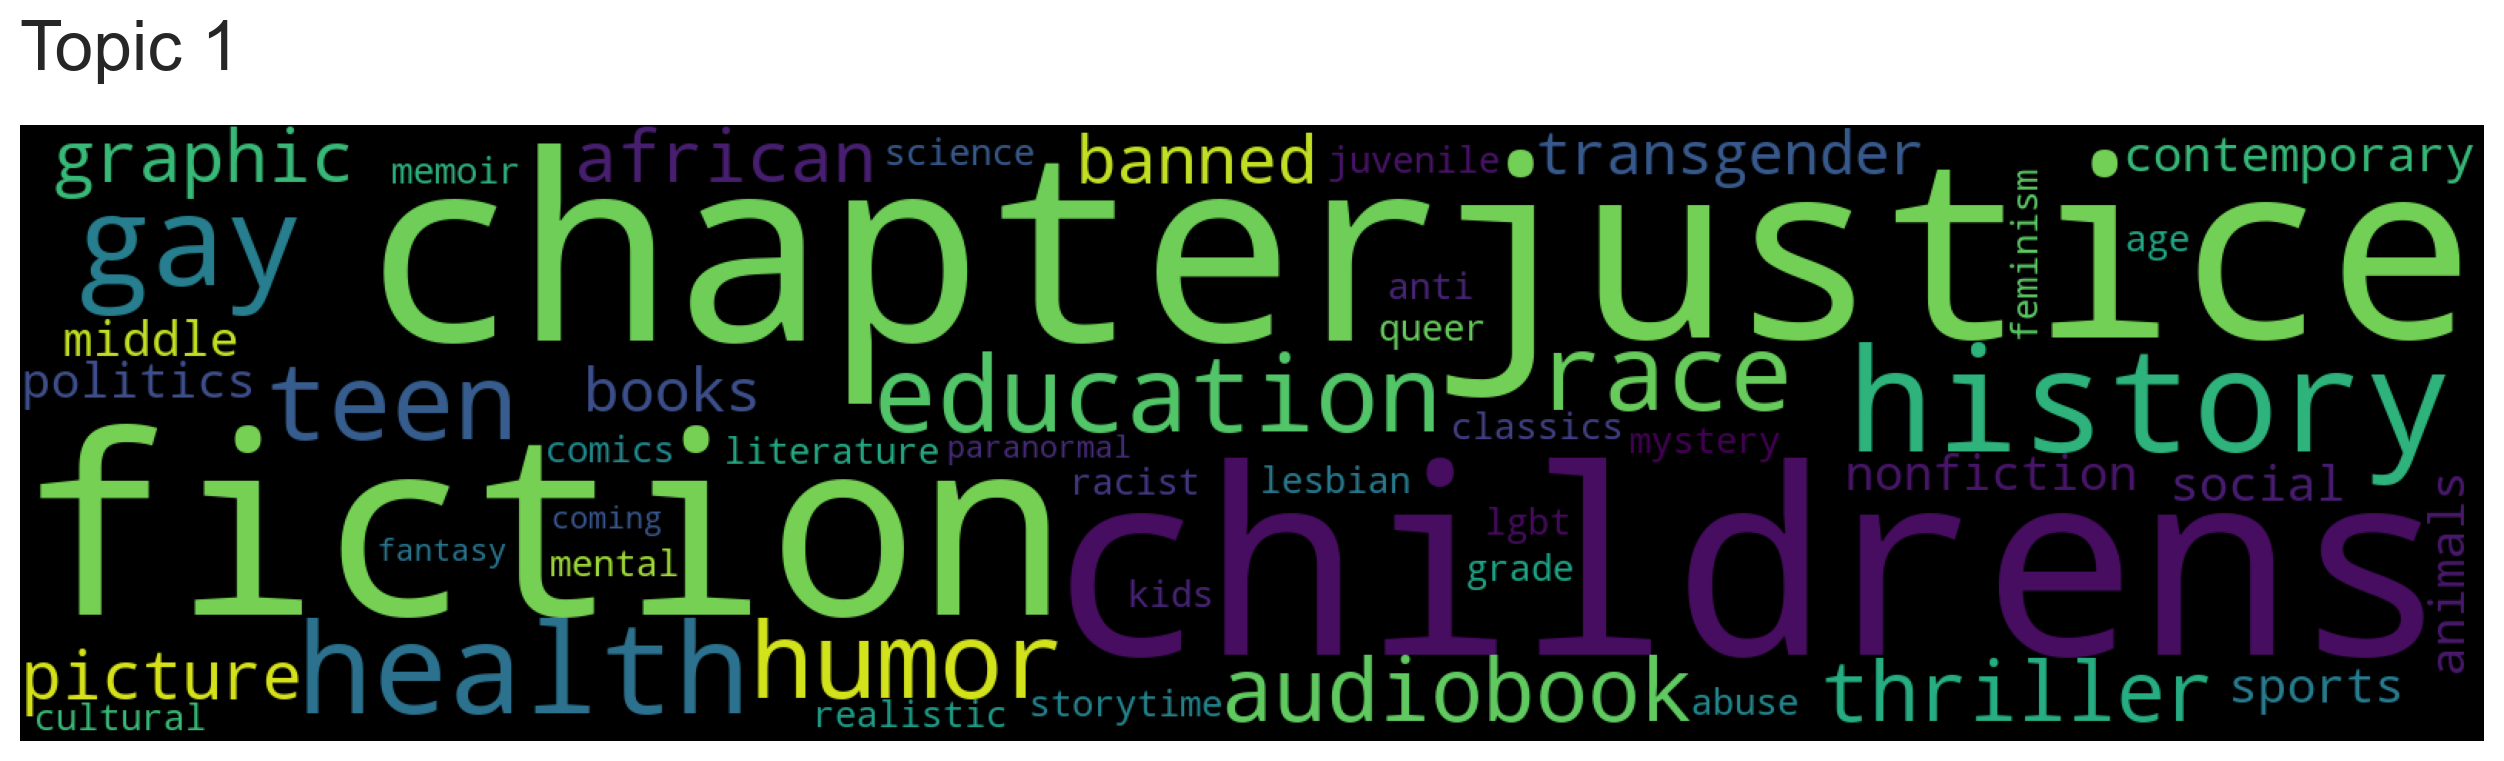

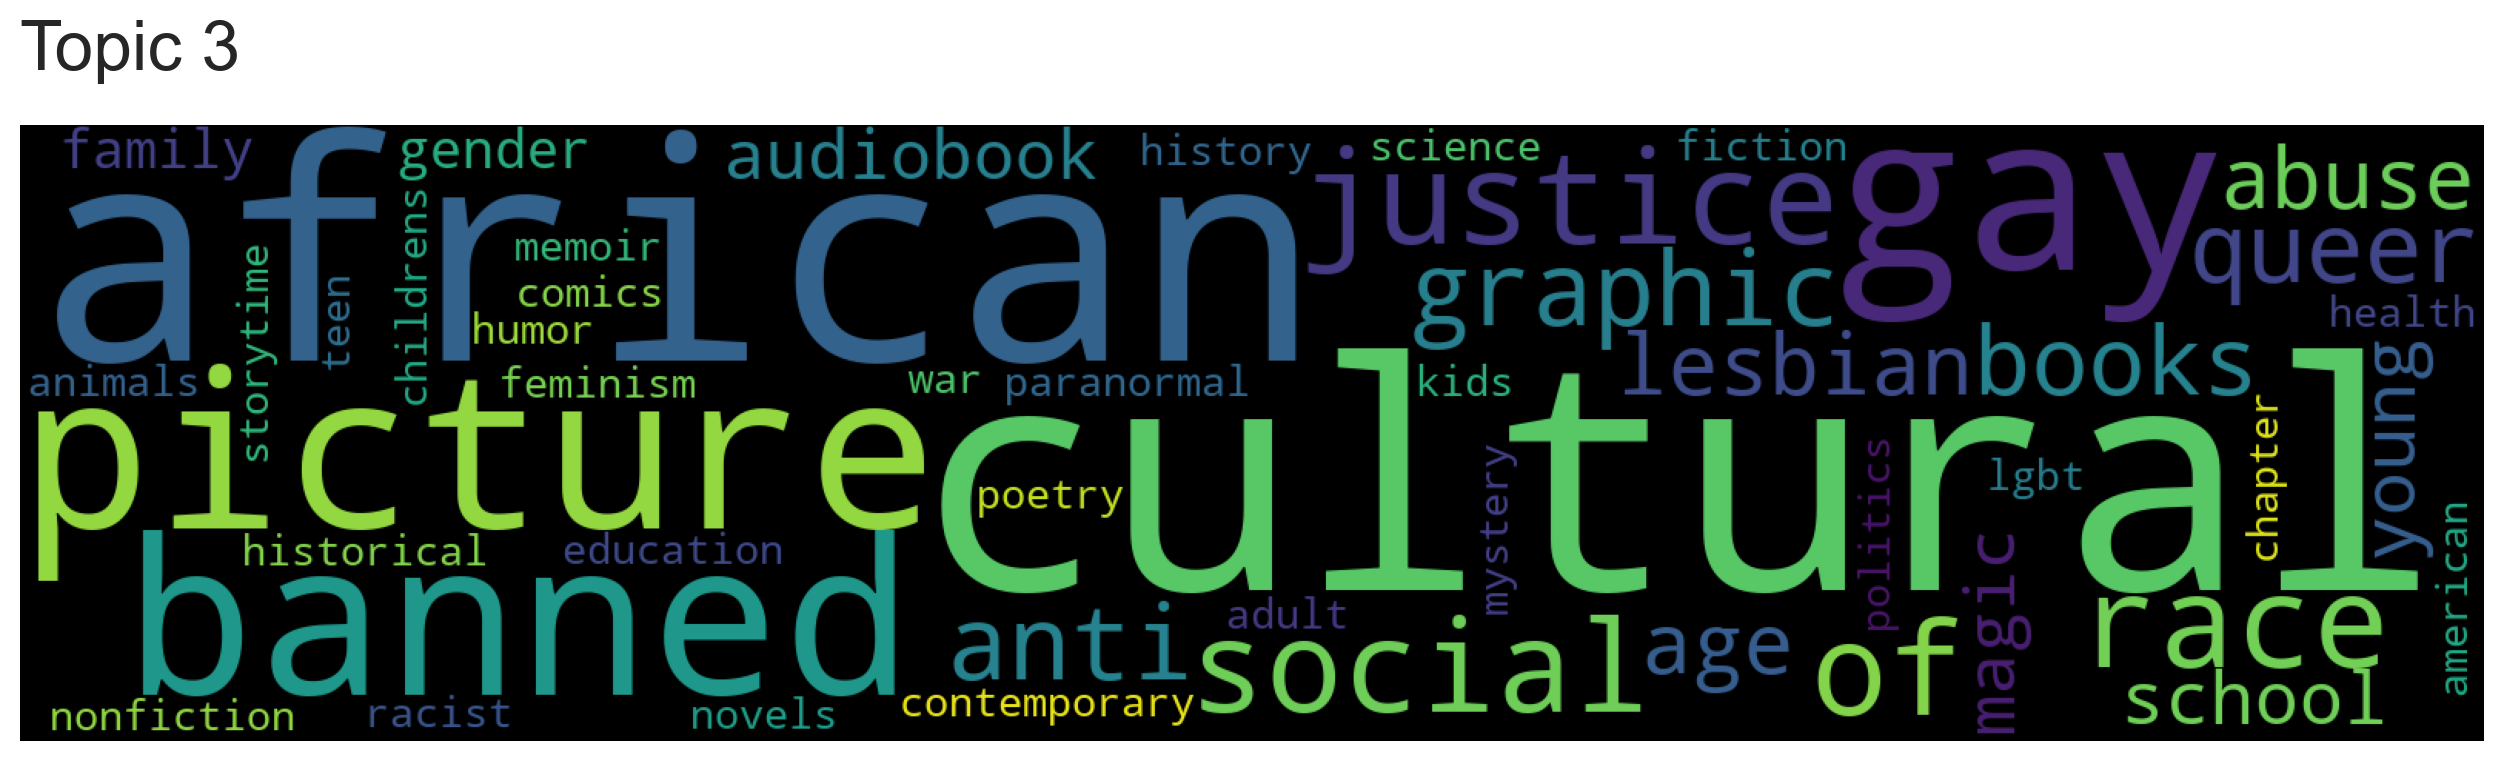

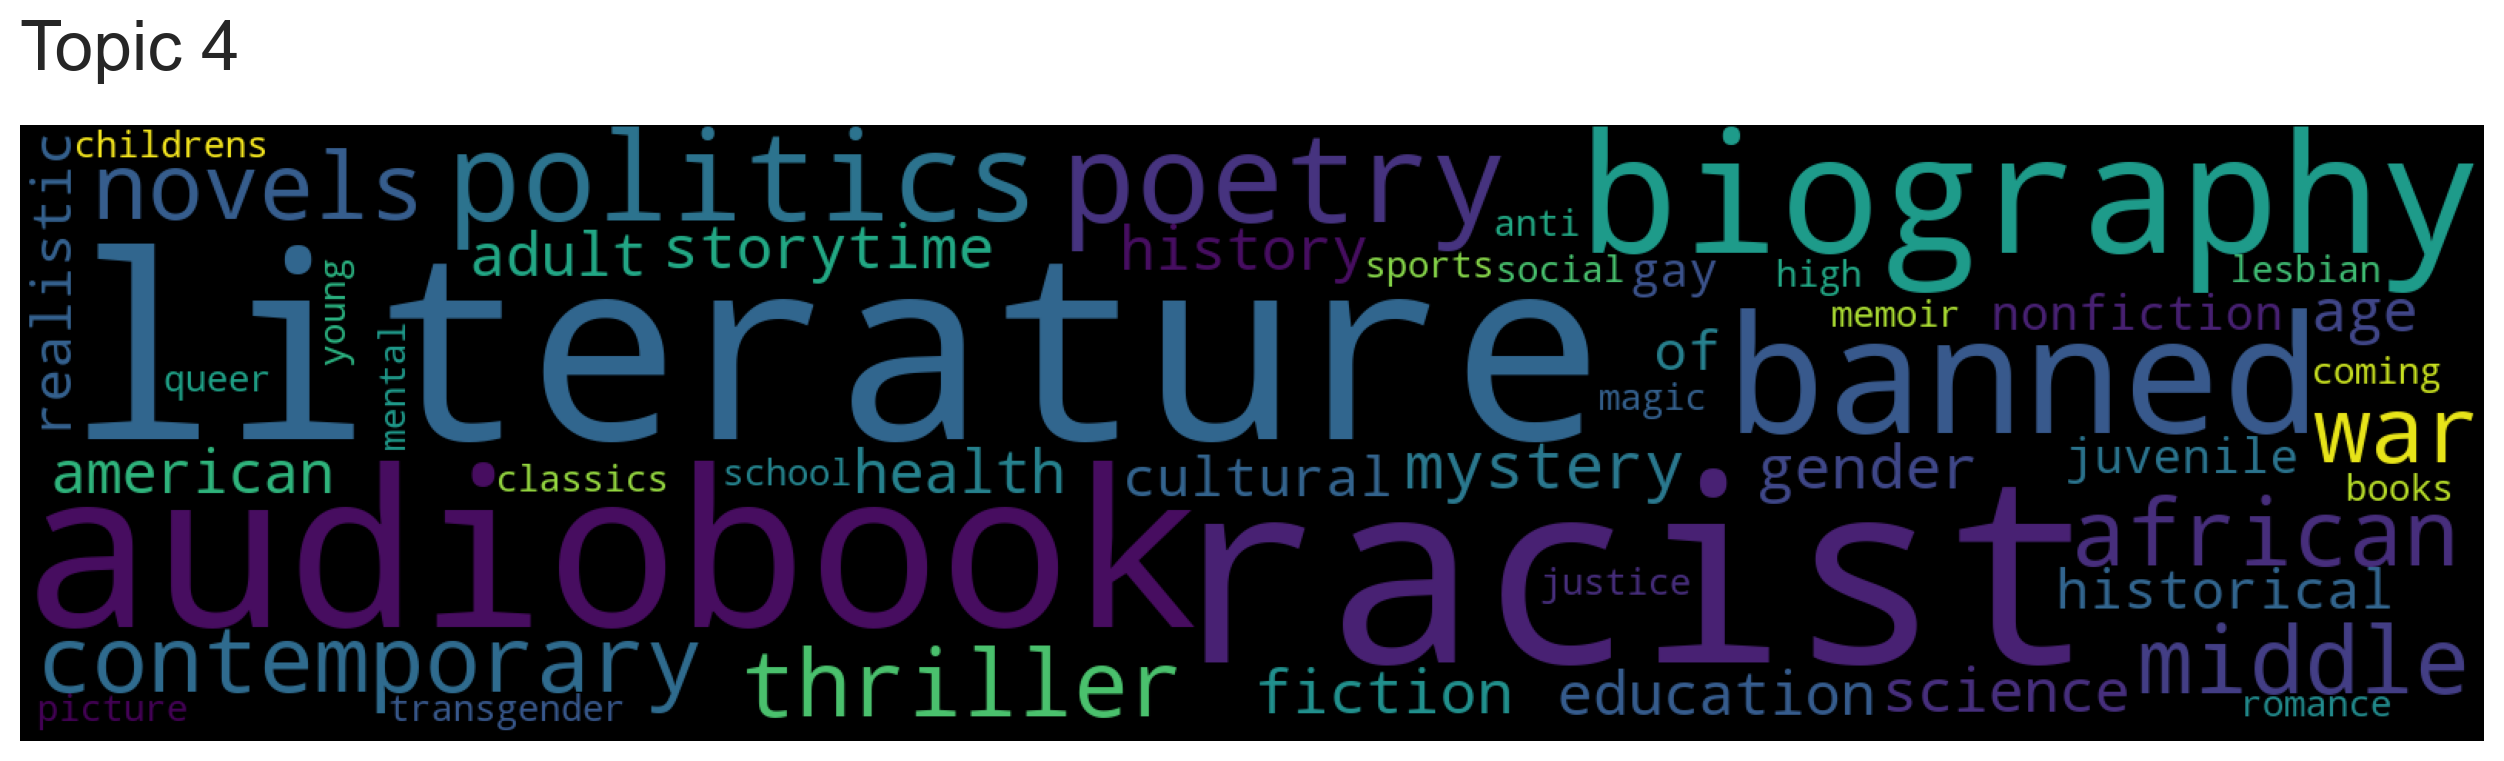

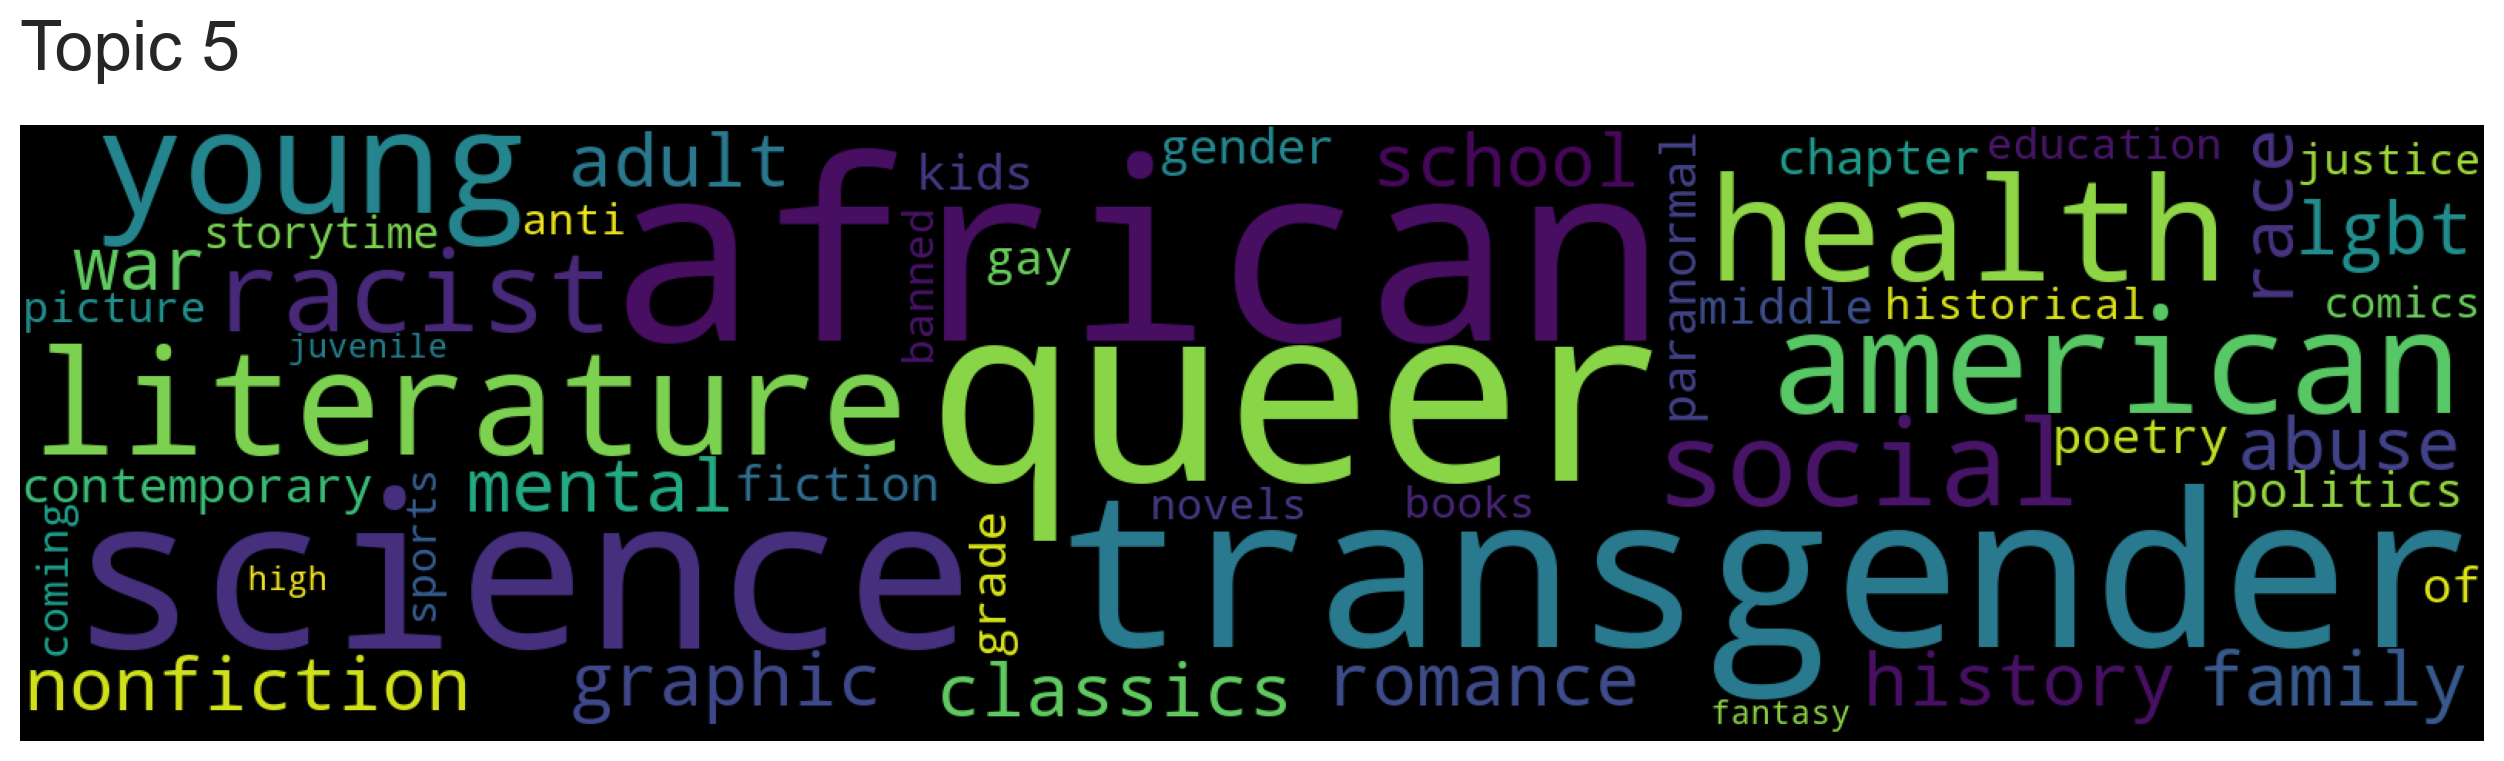

In [ ]:
for i in range(len(model.topic_words)):
    model.generate_topic_wordcloud(i)

In [ ]:
model2 = Top2Vec(banned_df['goodreads_description'].tolist())
model2.get_num_topics()

2023-03-26 14:52:38,222 - top2vec - INFO - Pre-processing documents for training
2023-03-26 14:52:38,719 - top2vec - INFO - Creating joint document/word embedding
2023-03-26 14:52:43,138 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-26 14:52:47,892 - top2vec - INFO - Finding dense areas of documents
2023-03-26 14:52:47,929 - top2vec - INFO - Finding topics


2

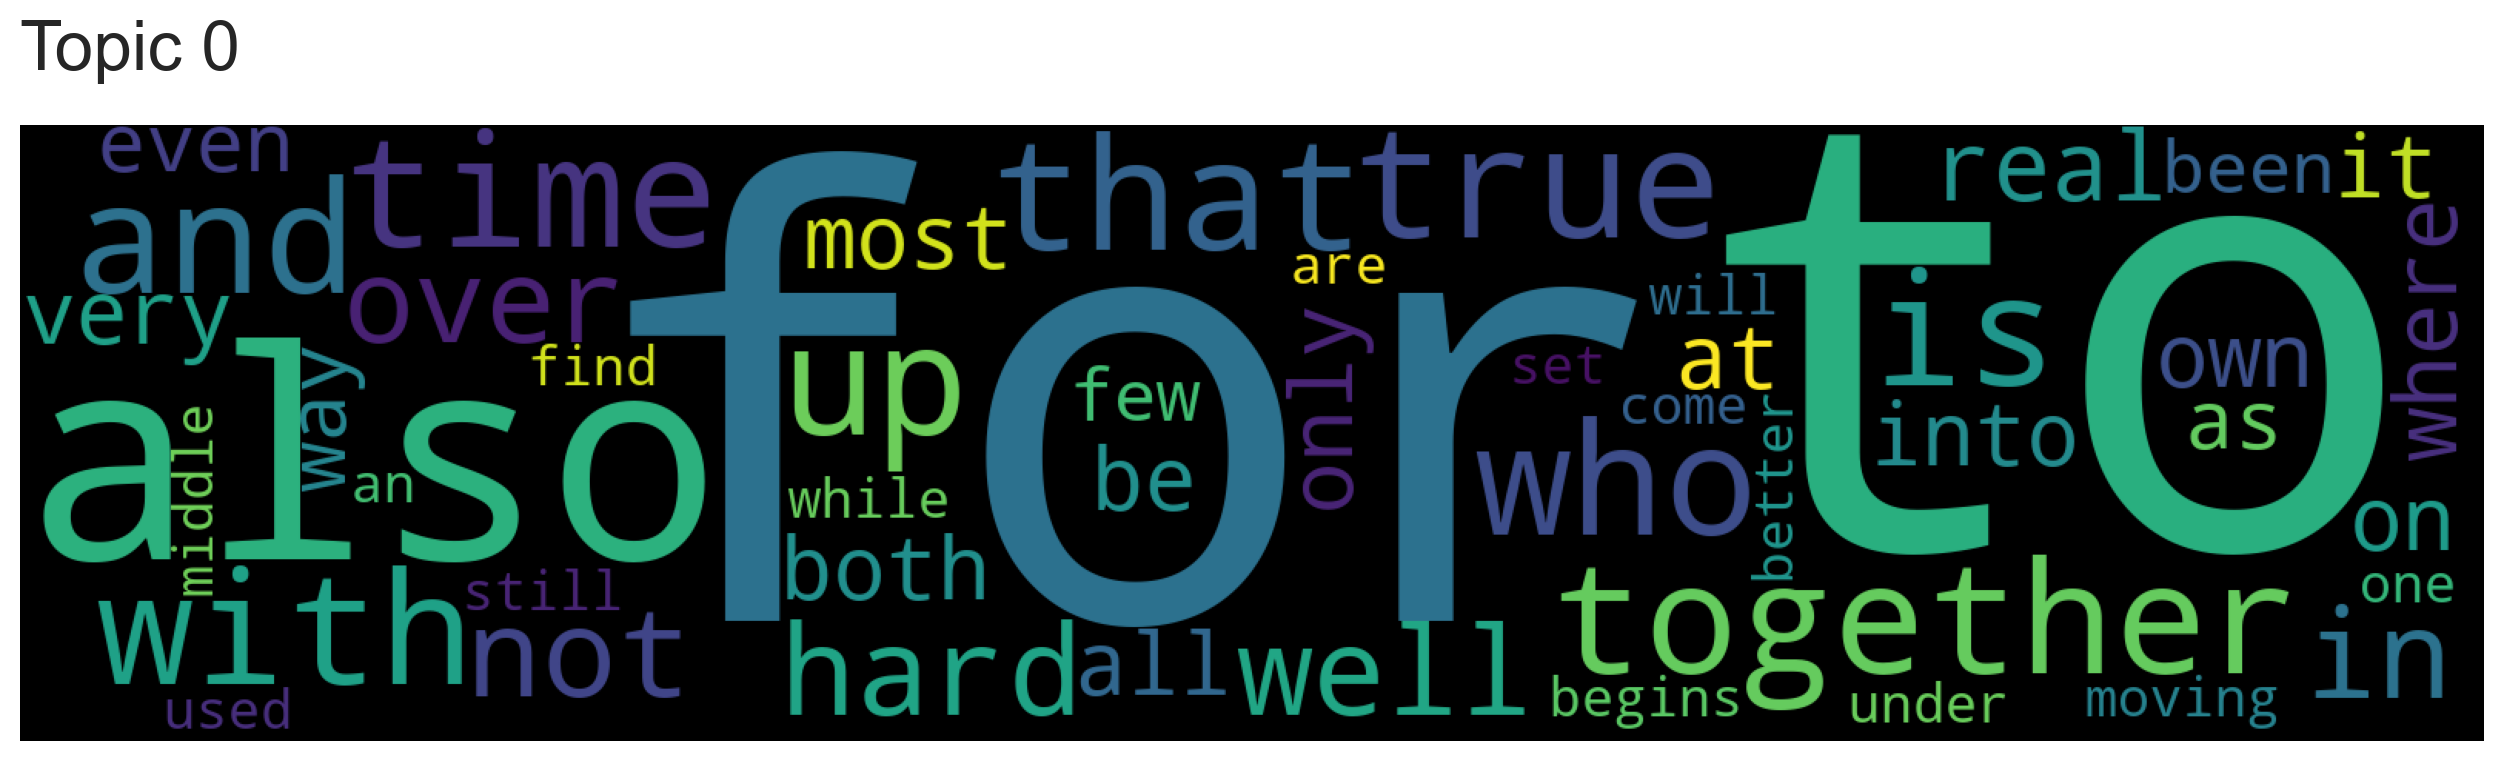

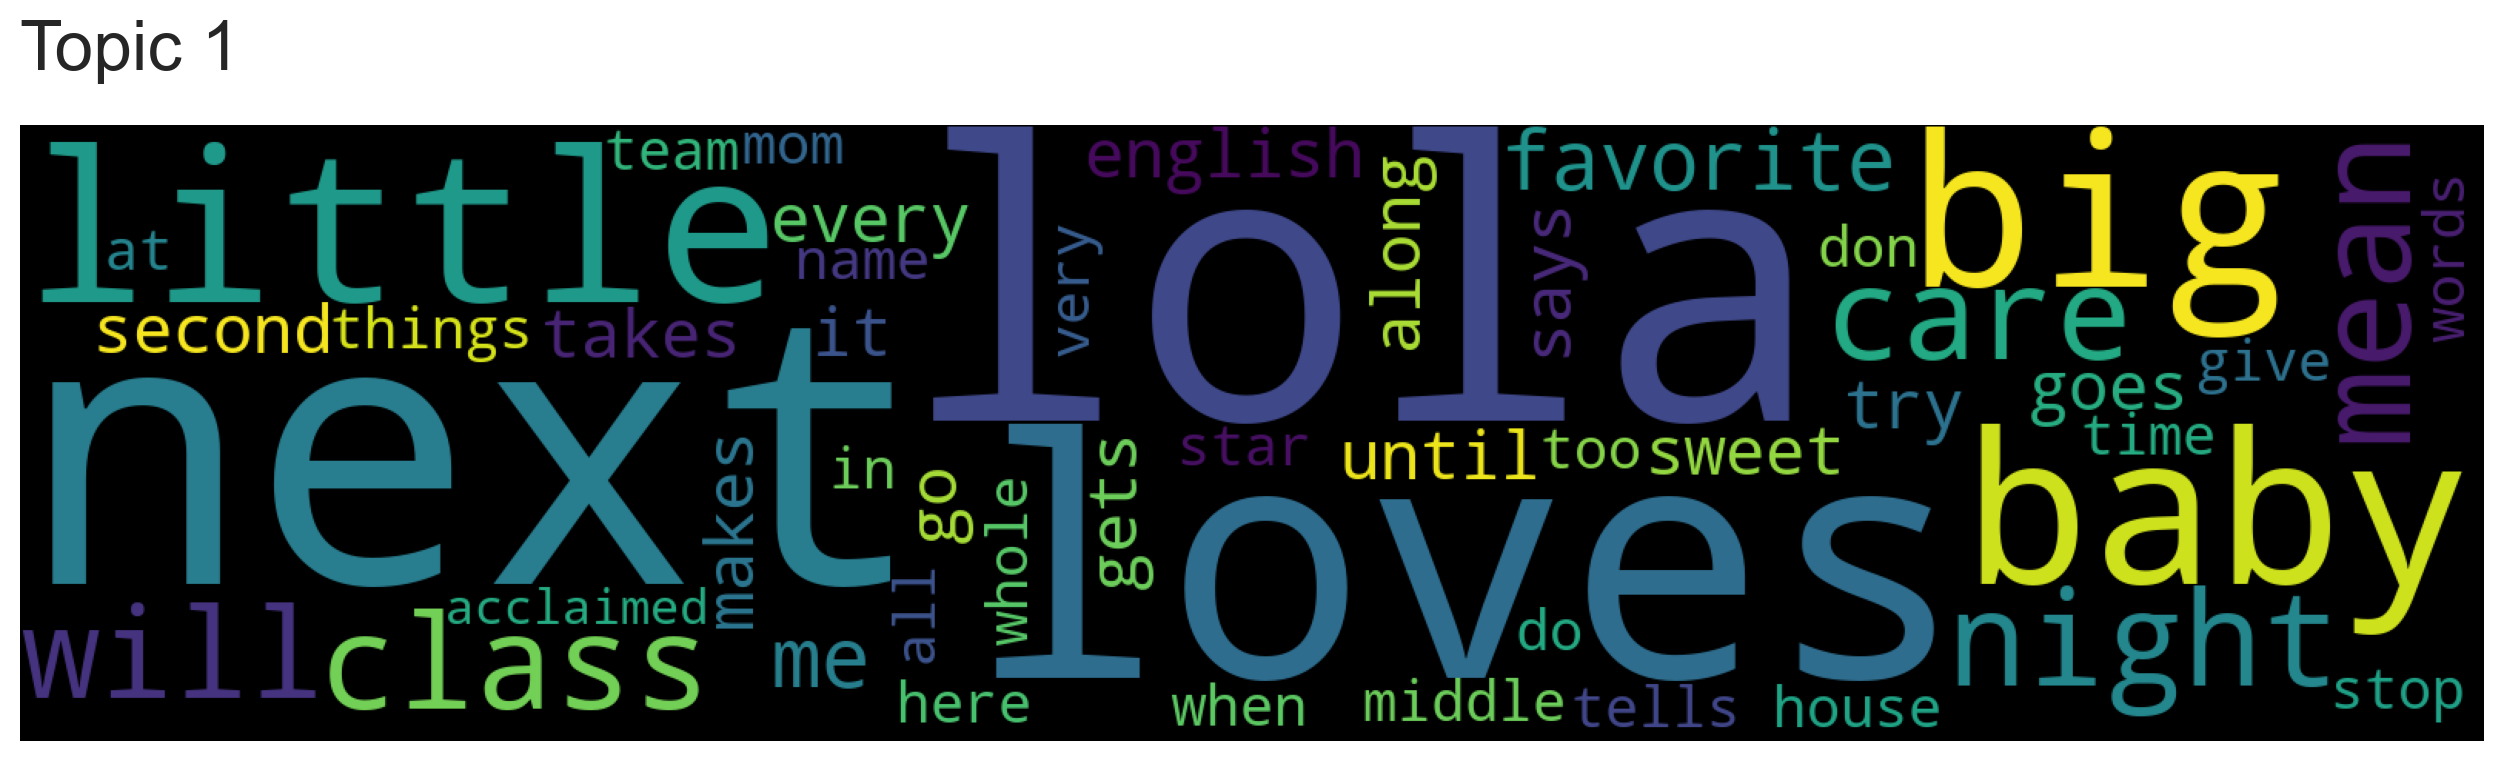

In [ ]:
for i in range(len(model2.topic_words)):
    model2.generate_topic_wordcloud(i)

In [ ]:
print(banned_df.head())

                                 goodreads_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
6  https://images-na.ssl-images-amazon.com/images...   
7  https://images-na.ssl-images-amazon.com/images...   

                                               title                  author  \
0                                      Ace of Spades  Àbíké-Íyímídé, Faridah   
1                                 Clap When You Land      Acevedo, Elizabeth   
2                                         The Poet X      Acevedo, Elizabeth   
6                               Call Me By Your Name           Aciman, André   
7  How I Paid for College: A Novel of Sex, Theft,...             Acito, Marc   

  goodreads_published_date                              goodreads_description  \
0               2021-06-01  An incendiary and utterly compelling thriller ...   
1               2020

In [ ]:
regexp = nltk.tokenize.RegexpTokenizer('\w+')

banned_df['token_desc'] = banned_df['goodreads_description'].apply(regexp.tokenize)


stopwords = stoplist
banned_df['text_token'] = banned_df['token_desc'].apply(lambda x: [item.lower() for item in x if item.lower() not in stoplist])

# banned_df['text_token'] = banned_df['text_token'].apply(lambda x: [item.text for item in x])
# from nltk.tokenize import word_tokenize
# banned_df['text_token'] = banned_df['token_desc'].apply(lambda x: word_tokenize(x))
print(banned_df['text_token'])


0       [incendiary, utterly, compelling, thriller, sh...
1       [verse, brims, grief, national, award, winning...
2       [fans, fall, hard, astonishing, york, times, b...
6       [call, sudden, powerful, romance, blossoms, ad...
7       [deliciously, funny, romp, overly, theatrical,...
                              ...                        
2527    [aliya, struggles, fit, feeling, confident, ta...
2528    [society, flooded, technology, enables, connec...
2529    [water, pain, sun, corner, american, street, r...
2530    [black, studded, anthology, edited, national, ...
2531    [beautifully, illustrated, connects, girl, bak...
Name: text_token, Length: 1644, dtype: object


In [ ]:
topic_words = banned_df['text_token'].astype(str).tolist()
print(topic_words)

["['incendiary', 'utterly', 'compelling', 'thriller', 'shocking', 'twist', 'delves', 'deep', 'heart', 'institutionalized', 'racism', 'exceptional', 'voice', 'niveus', 'private', 'money', 'paves', 'hallways', 'students', 'perfect', 'anonymous', 'texter', 'aces', 'bringing', 'students', 'dark', 'secrets', 'talented', 'musician', 'buries', 'rehearsals', 'escape', 'spotlight', 'private', 'photos', 'public', 'head', 'girl', 'chiamaka', 'isn', 'afraid', 'paid', 'holds', 'aces', 'planning', 'high', 'game']", "['verse', 'brims', 'grief', 'national', 'award', 'winning', 'york', 'times', 'bestselling', 'writes', 'devastation', 'loss', 'difficulty', 'forgiveness', 'bittersweet', 'bonds', 'shape', 'lives', 'camino', 'rios', 'lives', 'summers', 'father', 'visits', 'dominican', 'republic', 'time', 'day', 'plane', 'supposed', 'land', 'camino', 'arrives', 'airport', 'crowds', 'crying', 'york', 'city', 'yahaira', 'rios', 'called', 'principal', 'office', 'mother', 'waiting', 'father', 'hero', 'died', 'p

In [ ]:
model3 = Top2Vec(topic_words)
model3.get_num_topics()

2023-03-26 14:53:04,146 - top2vec - INFO - Pre-processing documents for training
2023-03-26 14:53:04,465 - top2vec - INFO - Creating joint document/word embedding
2023-03-26 14:53:08,022 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-26 14:53:13,654 - top2vec - INFO - Finding dense areas of documents
2023-03-26 14:53:13,687 - top2vec - INFO - Finding topics


2

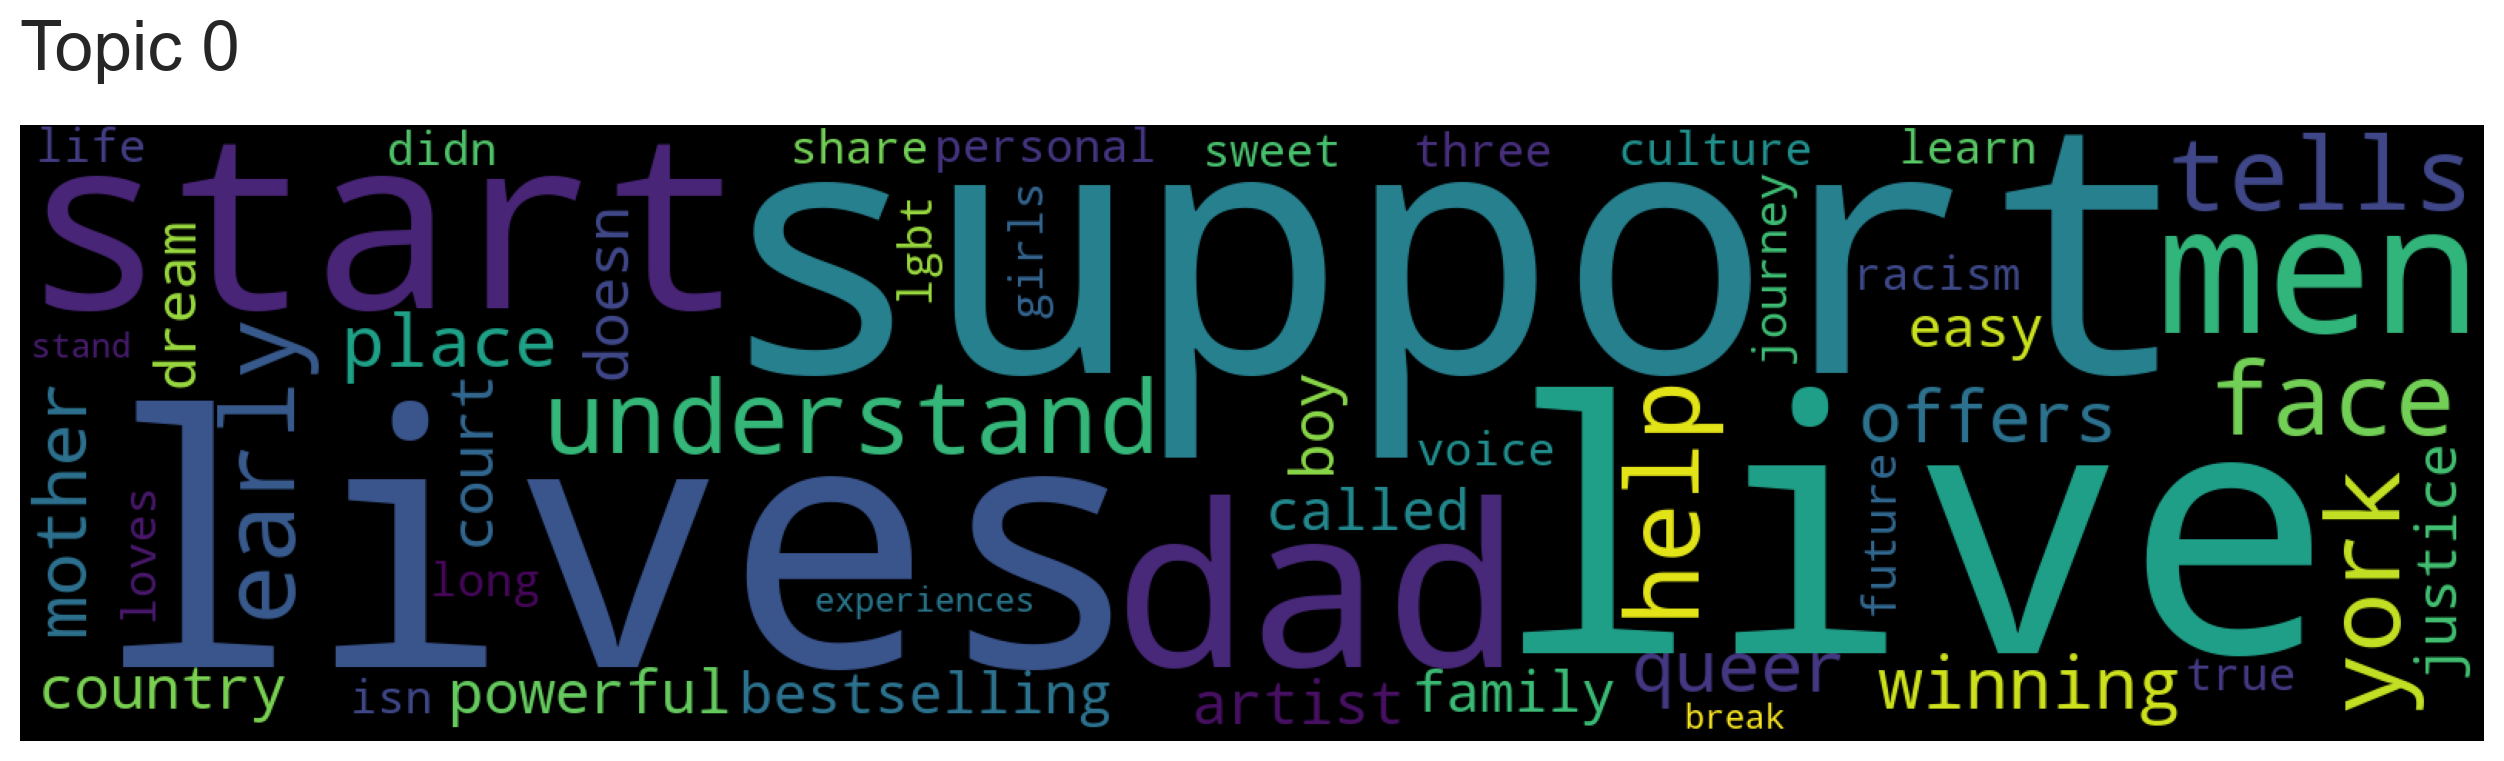

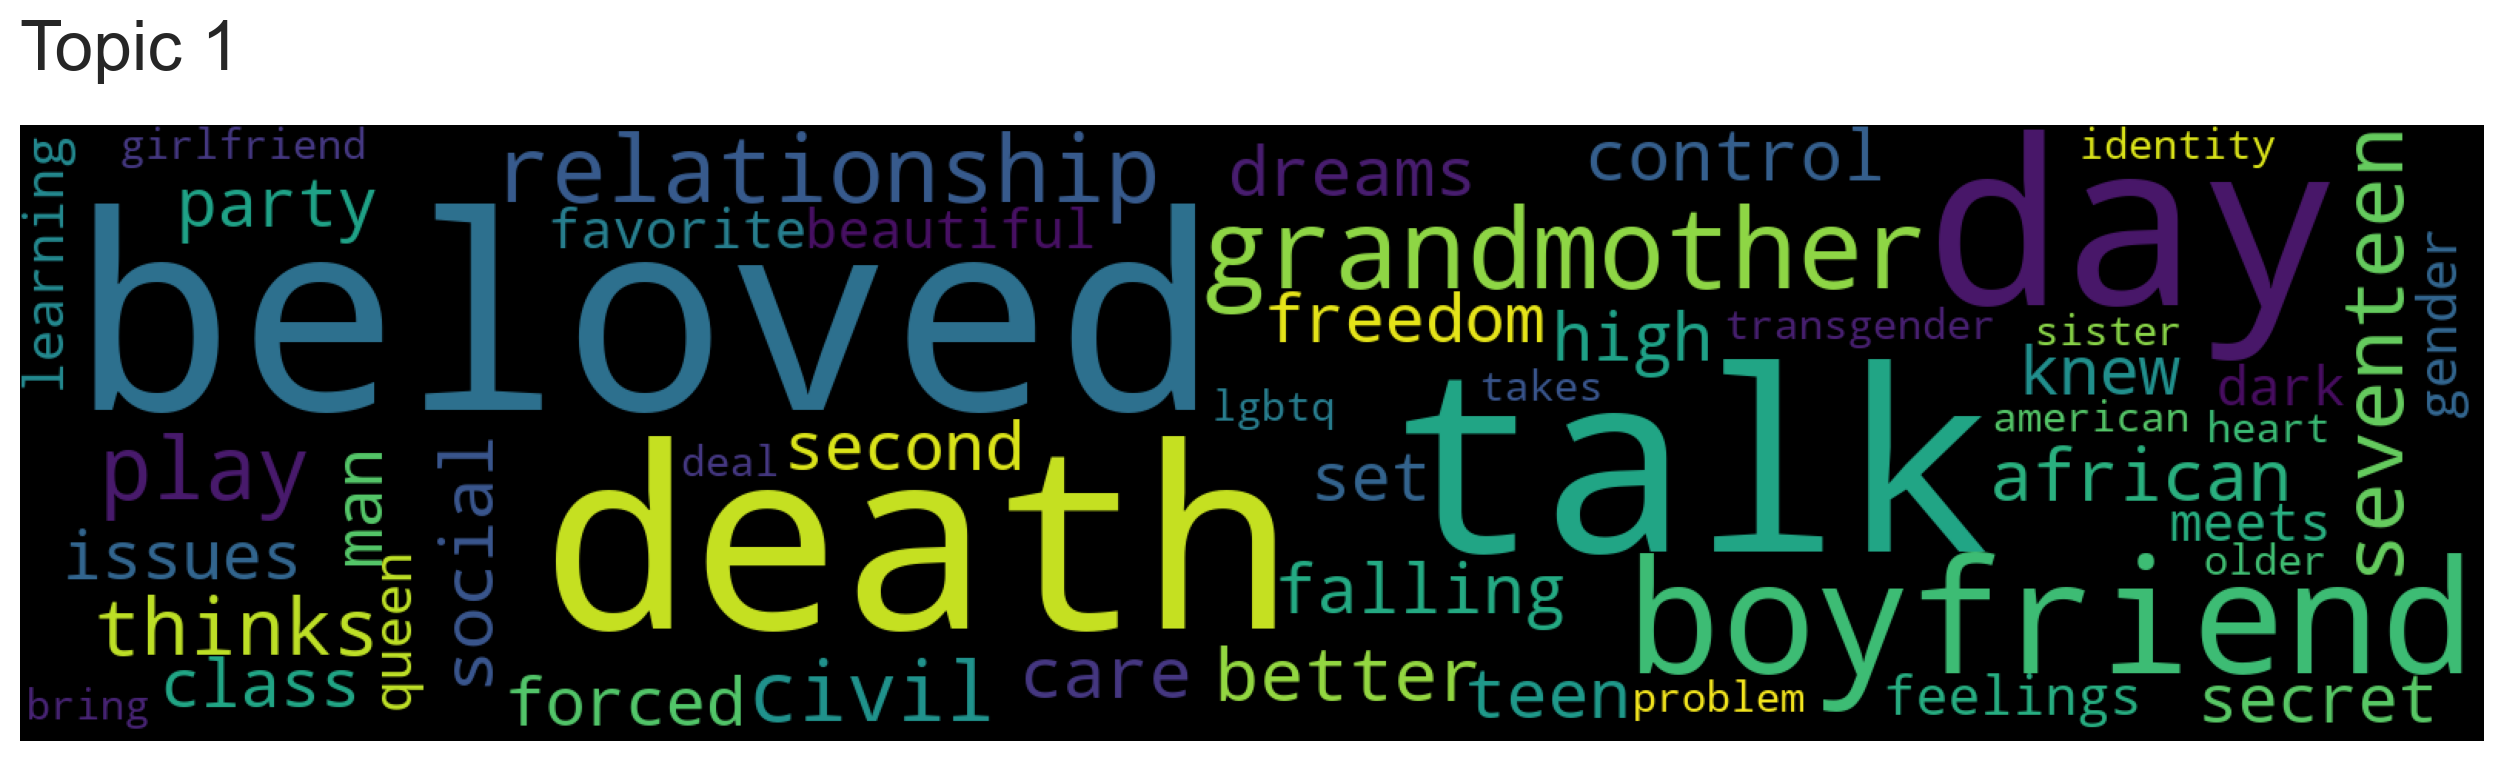

In [ ]:
for i in range(len(model3.topic_words)):
    model3.generate_topic_wordcloud(i)

In [ ]:
print(banned_df.head())

                                 goodreads_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
6  https://images-na.ssl-images-amazon.com/images...   
7  https://images-na.ssl-images-amazon.com/images...   

                                               title                  author  \
0                                      Ace of Spades  Àbíké-Íyímídé, Faridah   
1                                 Clap When You Land      Acevedo, Elizabeth   
2                                         The Poet X      Acevedo, Elizabeth   
6                               Call Me By Your Name           Aciman, André   
7  How I Paid for College: A Novel of Sex, Theft,...             Acito, Marc   

  goodreads_published_date                              goodreads_description  \
0               2021-06-01  An incendiary and utterly compelling thriller ...   
1               2020

In [ ]:
print(banned_df['goodreads_tags'])
print(banned_df['text_token'])
combo_d_and_t = [[i,*j] for i,j in zip(banned_df['goodreads_tags'], banned_df['text_token'])]


banned_df['combo_desc_and_tag'] = combo_d_and_t
print(banned_df['combo_desc_and_tag'])

0       dark, lgbtqia+, black, young adult, gay romanc...
1       young adult, poetry, contemporary, fiction, au...
2       poetry, young adult, contemporary, fiction, au...
6       queer literature, gay, coming of age, lgbtqia+...
7       fiction, young adult, humor, lgbt, gay, contem...
                              ...                        
2527    realistic fiction, religion, islam, fiction, m...
2528                       education, nonfiction, emotion
2529    young adult, contemporary, fiction, magical re...
2530    young adult, short stories, contemporary, anth...
2531    picture books, family, food, africa, childrens...
Name: goodreads_tags, Length: 1644, dtype: object
0       [incendiary, utterly, compelling, thriller, sh...
1       [verse, brims, grief, national, award, winning...
2       [fans, fall, hard, astonishing, york, times, b...
6       [call, sudden, powerful, romance, blossoms, ad...
7       [deliciously, funny, romp, overly, theatrical,...
                      

In [ ]:
banned_df['combo_desc_and_tag'][0]

['dark, lgbtqia+, black, young adult, gay romance, people of color, fantasy, crime, social justice, dark academia, teen & young adult, mystery, thriller,  suspense, high school, gay, teen, lesbian',
 'incendiary',
 'utterly',
 'compelling',
 'thriller',
 'shocking',
 'twist',
 'delves',
 'deep',
 'heart',
 'institutionalized',
 'racism',
 'exceptional',
 'voice',
 'niveus',
 'private',
 'money',
 'paves',
 'hallways',
 'students',
 'perfect',
 'anonymous',
 'texter',
 'aces',
 'bringing',
 'students',
 'dark',
 'secrets',
 'talented',
 'musician',
 'buries',
 'rehearsals',
 'escape',
 'spotlight',
 'private',
 'photos',
 'public',
 'head',
 'girl',
 'chiamaka',
 'isn',
 'afraid',
 'paid',
 'holds',
 'aces',
 'planning',
 'high',
 'game']

In [ ]:
topic_words_2 = banned_df['combo_desc_and_tag'].astype(str).tolist()
model4 = Top2Vec(topic_words_2)
model4.get_num_topics()

2023-03-26 14:57:15,215 - top2vec - INFO - Pre-processing documents for training
2023-03-26 14:57:15,609 - top2vec - INFO - Creating joint document/word embedding
2023-03-26 14:57:20,370 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-26 14:57:25,562 - top2vec - INFO - Finding dense areas of documents
2023-03-26 14:57:25,592 - top2vec - INFO - Finding topics


3

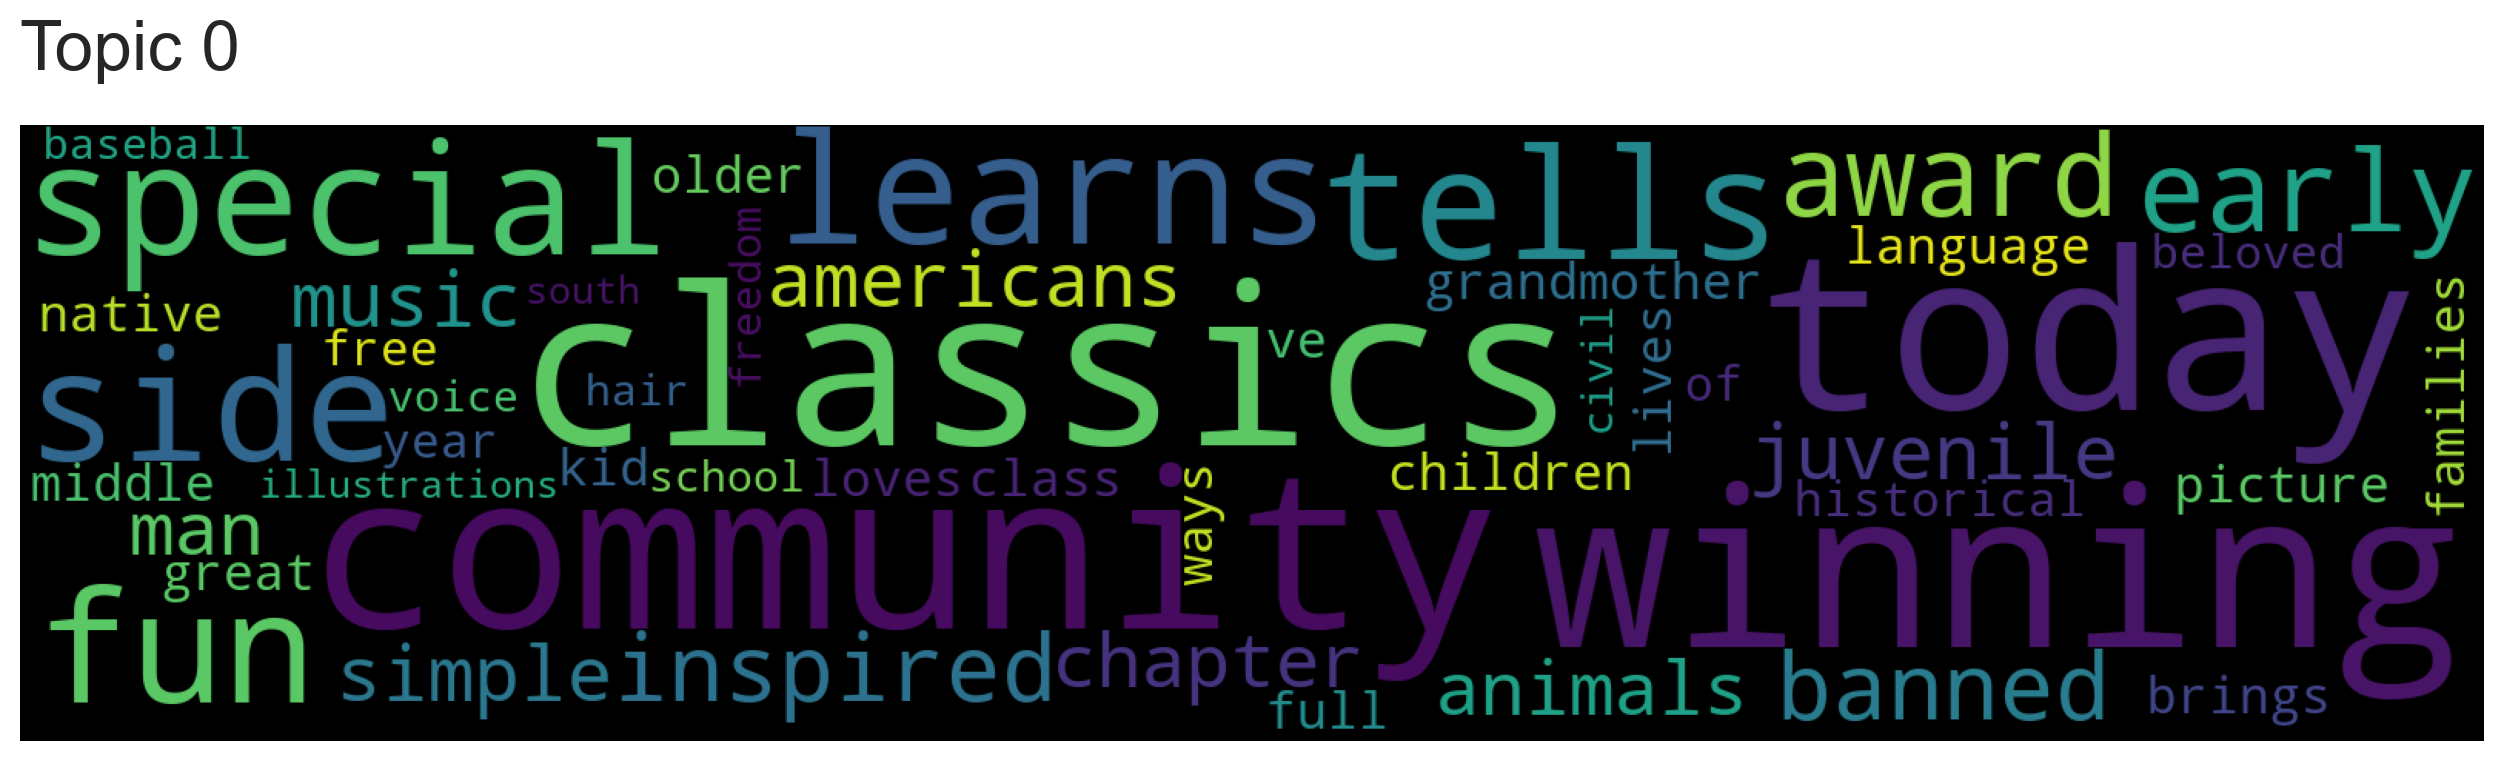

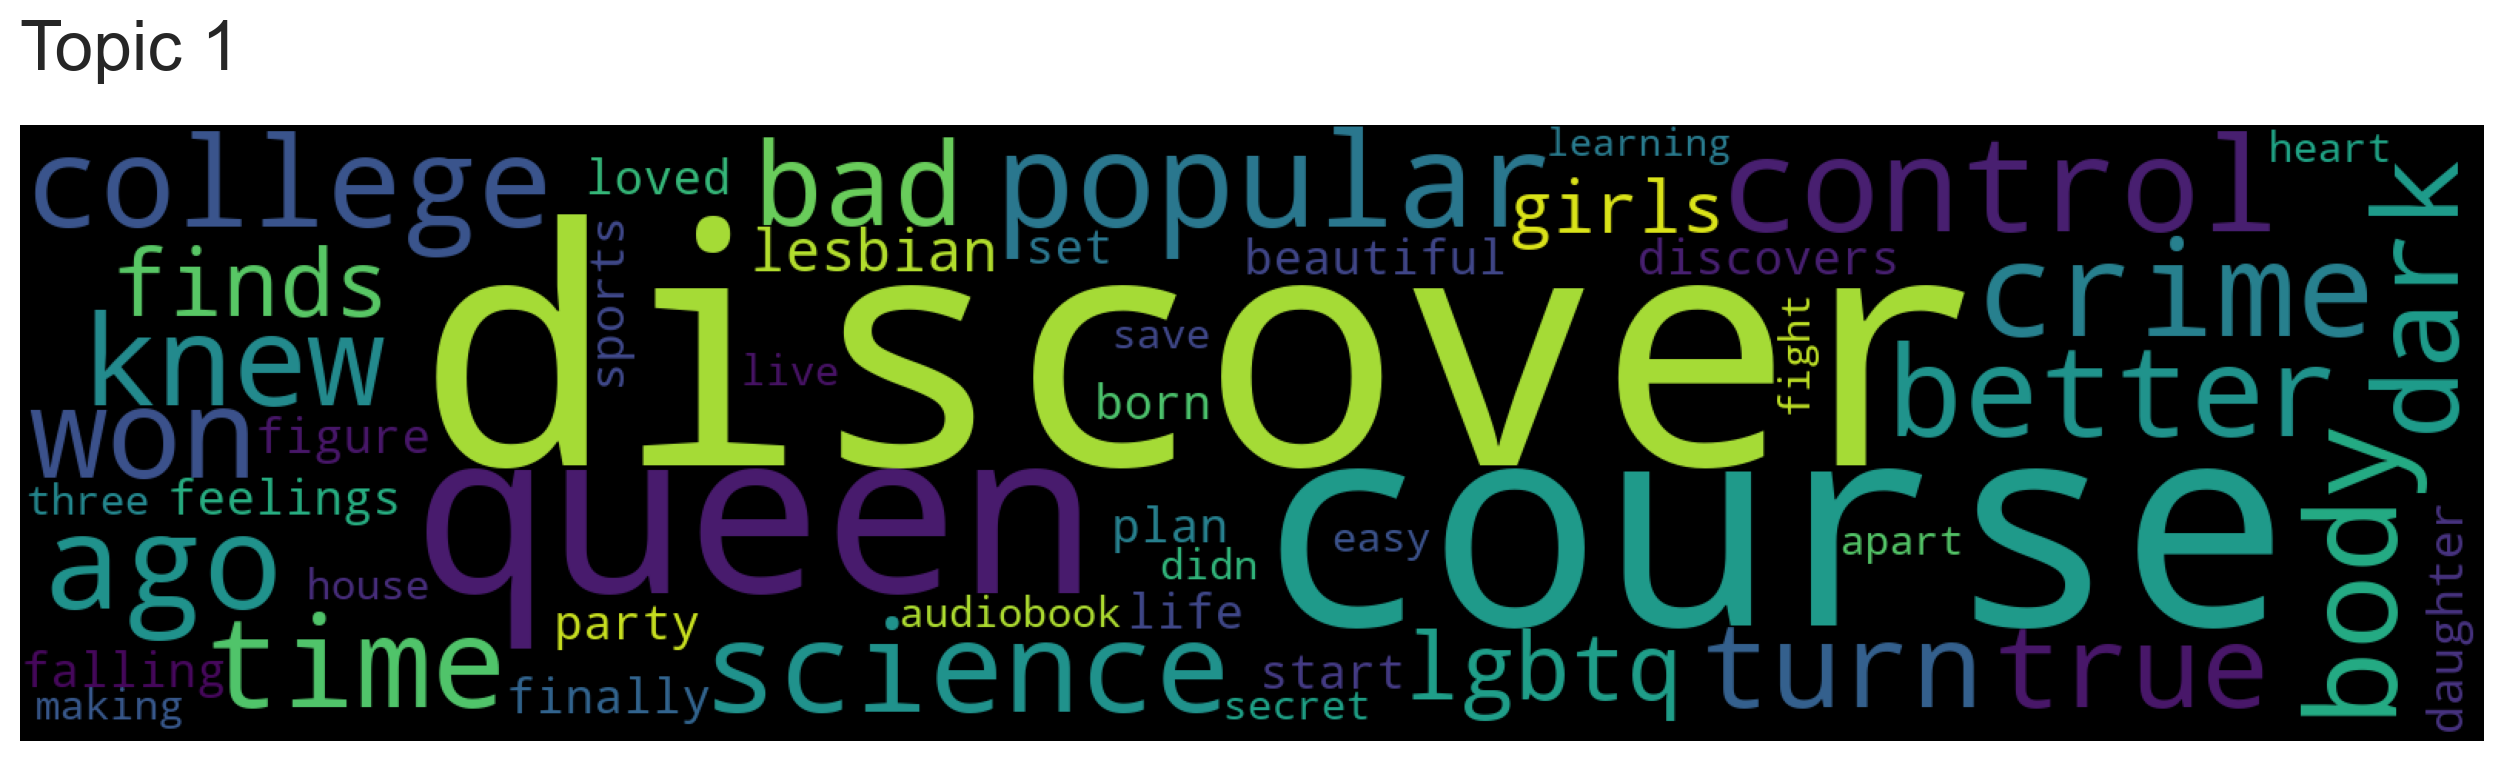

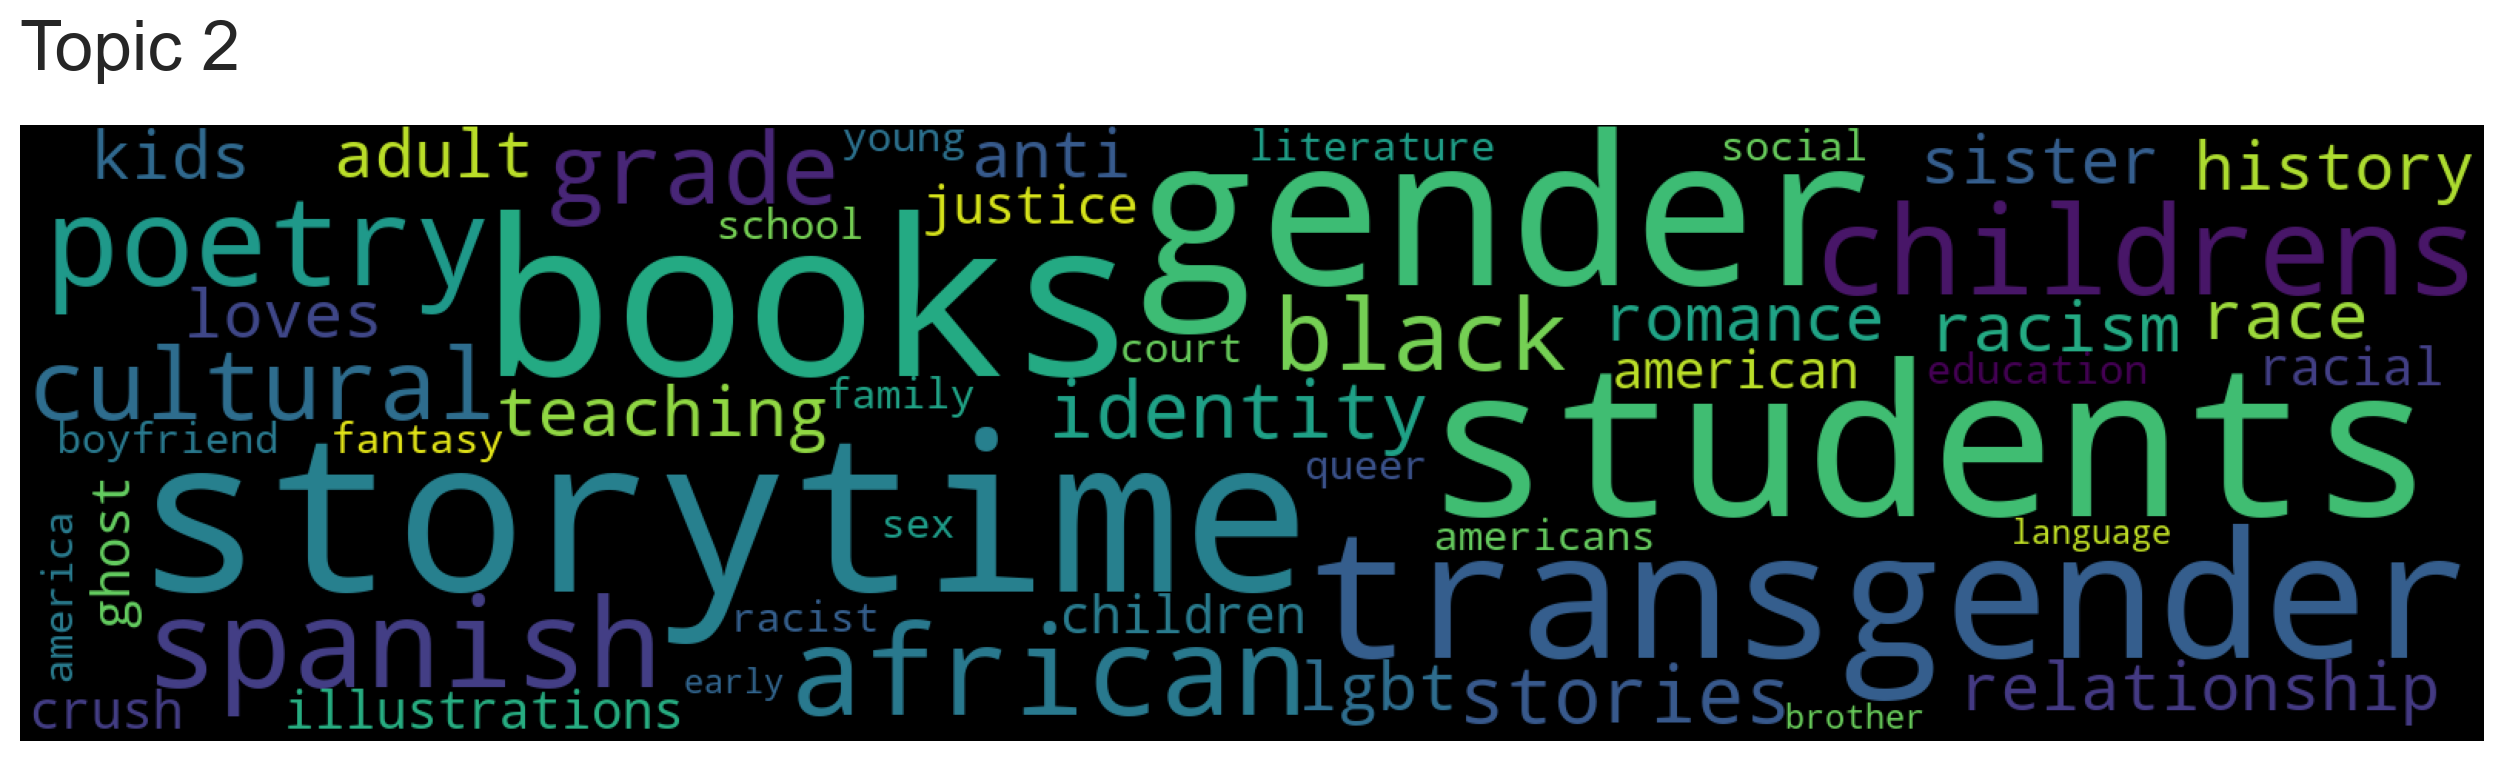

In [ ]:
for i in range(len(model4.topic_words)):
    model4.generate_topic_wordcloud(i)